In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import pitching_stats,statcast,team_pitching_bref
import numpy
numpy.random.seed(4812)
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Create pitch plinko style graphs

Using data pulled from pybaseball to re-create a visual similar to https://baseballsavant.mlb.com/visuals/pitch-plinko?playerId=594798&playerName=Jacob%20deGrom



In [2]:
import networkx

`statcast` was used to pull Cubs data before and after the all star break, then written to CSVs.
Here they are read back in an made a sigle datafr

In [3]:
test_df = pd.read_csv('chc_2017_before_asb.csv')
test_df2 = pd.read_csv('chc_2017_after_asb.csv')

In [4]:
test_df = pd.concat([test_df,test_df2])

Use pitching_stats to get a list of pictures in 2017.

In [5]:
pitching_2017 = pitching_stats(2017,qual=1)

Filter to just Cubs and pitchers with at least 20 innings pitched.

In [6]:
pitching_2017 = pitching_2017[(pitching_2017['Team'] == 'CHC') & 
                              (pitching_2017['IP'] >= 20)]

Select specifc columns and sort the dataframe by `game_date`,`at_bat_number`,`strikes`,`balls`.
This is needed to establish a row number and order of evenets. Each at bar starts with an `0-0` count and does not increment until the batter reaches base or is out.

In [7]:
ordered_df = test_df[['player_name','pitch_type',
                      'game_date','home_team','away_team','description','events',
                      'strikes','balls','inning','inning_topbot',
                      'at_bat_number','release_pos_x','release_pos_z',
                      'plate_x','plate_z','pfx_x','pfx_z','sz_top', 'sz_bot',
                      'release_speed']].sort_values(by=['game_date','at_bat_number','strikes','balls'])

In [8]:
ordered_df[ordered_df['player_name'] == 'Jon Lester'].head(5)

,player_name,pitch_type,game_date,home_team,away_team,description,events,strikes,balls,inning,...,at_bat_number,release_pos_x,release_pos_z,plate_x,plate_z,pfx_x,pfx_z,sz_top,sz_bot,release_speed
24956,Jon Lester,FF,2017-04-02,STL,CHC,ball,NaN,0.0,0.0,1.0,...,5.0,2.9944,5.5975,-0.5114,1.1422,0.8282,1.2200,3.4458,1.6904,91.3
24955,Jon Lester,SI,2017-04-02,STL,CHC,ball,NaN,0.0,1.0,1.0,...,5.0,3.2075,5.8483,1.2630,2.4263,1.2946,0.7653,3.4853,1.7180,89.7
24954,Jon Lester,SI,2017-04-02,STL,CHC,hit_into_play,field_out,0.0,2.0,1.0,...,5.0,3.0696,5.5905,-0.0396,1.3787,0.9767,0.6362,3.8779,1.8182,88.2
24953,Jon Lester,FF,2017-04-02,STL,CHC,ball,NaN,0.0,0.0,1.0,...,6.0,2.9692,5.5241,-1.3883,2.0680,0.5675,1.3832,3.5255,1.6895,91.1
24952,Jon Lester,FF,2017-04-02,STL,CHC,hit_into_play_no_out,double,0.0,1.0,1.0,...,6.0,3.0488,5.6283,0.4130,2.3988,0.9409,1.3783,3.9850,1.7000,91.3


In [9]:
cubs_pitching = ordered_df.copy()

Create a list of the pitcher names

In [10]:
cubs_pitching = ordered_df[ordered_df['player_name'].isin(pitching_2017['Name'].unique())]

In [11]:
cubs_pitching.head()

,player_name,pitch_type,game_date,home_team,away_team,description,events,strikes,balls,inning,...,at_bat_number,release_pos_x,release_pos_z,plate_x,plate_z,pfx_x,pfx_z,sz_top,sz_bot,release_speed
24956,Jon Lester,FF,2017-04-02,STL,CHC,ball,NaN,0.0,0.0,1.0,...,5.0,2.9944,5.5975,-0.5114,1.1422,0.8282,1.2200,3.4458,1.6904,91.3
24955,Jon Lester,SI,2017-04-02,STL,CHC,ball,NaN,0.0,1.0,1.0,...,5.0,3.2075,5.8483,1.2630,2.4263,1.2946,0.7653,3.4853,1.7180,89.7
24954,Jon Lester,SI,2017-04-02,STL,CHC,hit_into_play,field_out,0.0,2.0,1.0,...,5.0,3.0696,5.5905,-0.0396,1.3787,0.9767,0.6362,3.8779,1.8182,88.2
24953,Jon Lester,FF,2017-04-02,STL,CHC,ball,NaN,0.0,0.0,1.0,...,6.0,2.9692,5.5241,-1.3883,2.0680,0.5675,1.3832,3.5255,1.6895,91.1
24952,Jon Lester,FF,2017-04-02,STL,CHC,hit_into_play_no_out,double,0.0,1.0,1.0,...,6.0,3.0488,5.6283,0.4130,2.3988,0.9409,1.3783,3.9850,1.7000,91.3


Create a string representing count (e.g. `0-0`,`0-1`)

In [12]:
cubs_pitching['pitch_count'] = ['{}-{}'.format(str(int(b)),str(int(s))) 
                                for b,s in zip(cubs_pitching['balls'],cubs_pitching['strikes'])]

Normalize the strike zone relative to center given the vertical `sz_top` and `sz_bottom` values are different for each batter.

In [13]:
cubs_pitching['sz_center'] = (cubs_pitching.sz_top+cubs_pitching.sz_bot)*0.5    

cubs_pitching['plate_z_norm'] = (((cubs_pitching['plate_z'].values - cubs_pitching['sz_center'].values)*2.0)/
                       (cubs_pitching.sz_top.values-cubs_pitching.sz_bot.values))
cubs_pitching['plate_x_norm'] = (cubs_pitching['plate_x'])/0.8391667

Reset index to create a row number

In [14]:
cubs_pitching = cubs_pitching.reset_index(drop=True).reset_index().rename(columns={'index':'rn'})

Save of resulting df

In [15]:
cubs_pitching.to_csv('cubs_2017_pitching_data.csv')

Pitch count dict. The keys represet starting counts a batter can have at any given time. The values are lists that have the possible next counts that can result after each pitch.

In [16]:
count_dict = {'0-0':['0-1','1-0'],
              '0-1':['1-1','0-2',],
              '0-2':['1-2'],
              '1-0':['1-1','2-0',],
              '1-1':['2-1','1-2'],
              '1-2':['2-2'],
              '2-0':['2-1','3-0'],
              '2-1':['3-1','2-2'],
              '2-2':['3-2'],
              '3-1':['3-2'],
              '3-0':['3-1']}

`countJoin` is used to join each starting count to the next possible counts in the sequence. The created row number is used to make sure that the correct pitch numbers are linked.

In [17]:
def countJoin(df,starting_count,count_dict=count_dict):
    keep_colums = ['rn','game_date','pitch_type','at_bat_number','pitch_count','description']
    starting_df = df.copy()
    starting_df = df[df['pitch_count']==starting_count][keep_colums]
    
    temp_list = []
    for counts in count_dict[starting_count]:
        temp_df = df[df['pitch_count']==counts][keep_colums]
        temp_merge = pd.merge(starting_df,
                              temp_df,
                              on=['at_bat_number','game_date'],
                              suffixes=('_start','_end'))
        temp_list.append(temp_merge[temp_merge['rn_end'] == temp_merge['rn_start']+1])
    
    count_df = pd.concat(temp_list)
    
    return count_df

See Jon Lester example starting with a `1-0` count.

In [18]:
lester_df = countJoin(cubs_pitching[cubs_pitching['player_name'] == 'Jon Lester'],starting_count='0-0')

There is extra info that will be used else where, but we can see that row number 5 is linked to row number 6.

In [19]:
lester_df.head()

,rn_start,game_date,pitch_type_start,at_bat_number,pitch_count_start,description_start,rn_end,pitch_type_end,pitch_count_end,description_end
0,5,2017-04-02,FF,7.0,0-0,swinging_strike,6,FC,0-1,foul
1,21,2017-04-02,FF,13.0,0-0,foul,22,FC,0-1,hit_into_play_no_out
2,23,2017-04-02,CU,14.0,0-0,called_strike,24,CU,0-1,blocked_ball
3,30,2017-04-02,FF,15.0,0-0,called_strike,31,SI,0-1,ball
4,37,2017-04-02,FF,16.0,0-0,foul,38,FF,0-1,foul


loop through all pitchers and pitch count sequences

During this loop a node-edge list is created using `networkx` and saved off to be used in Tableau later.

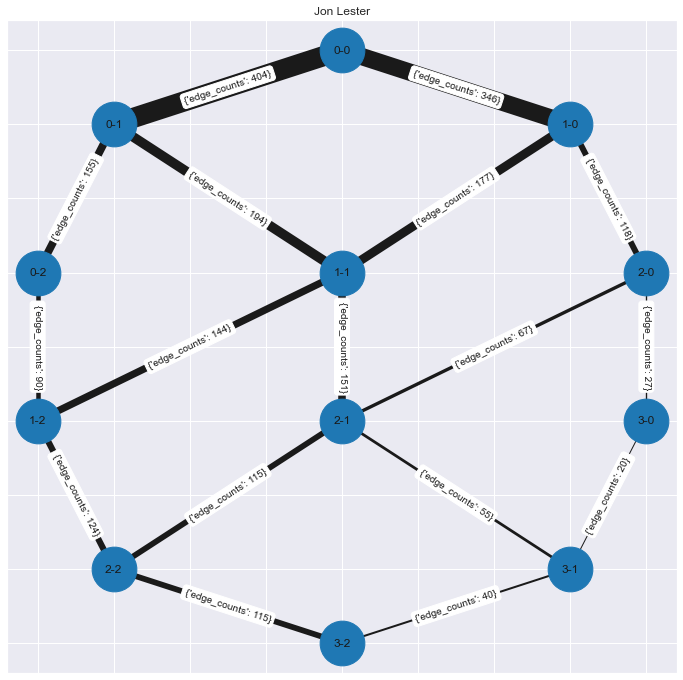

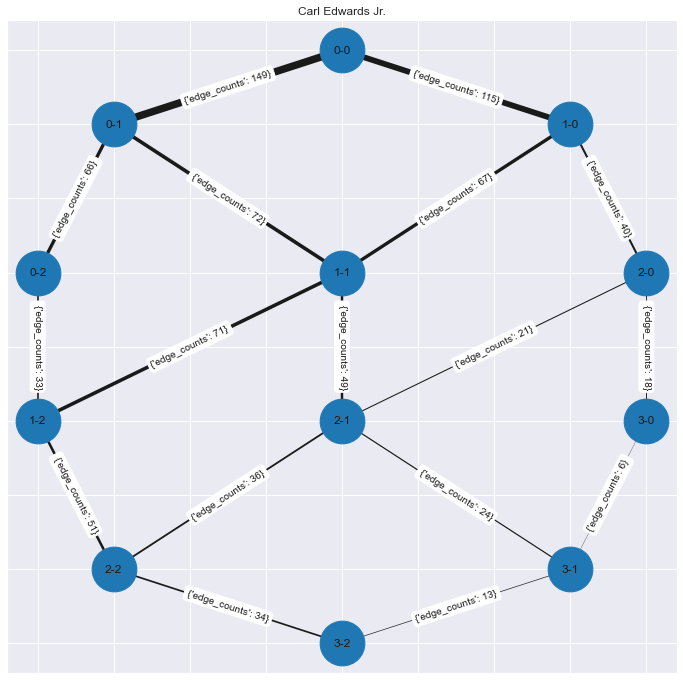

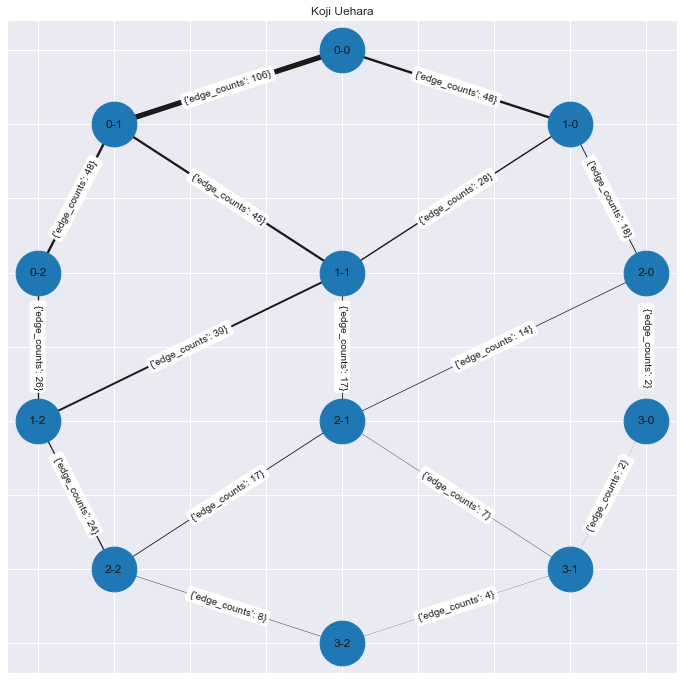

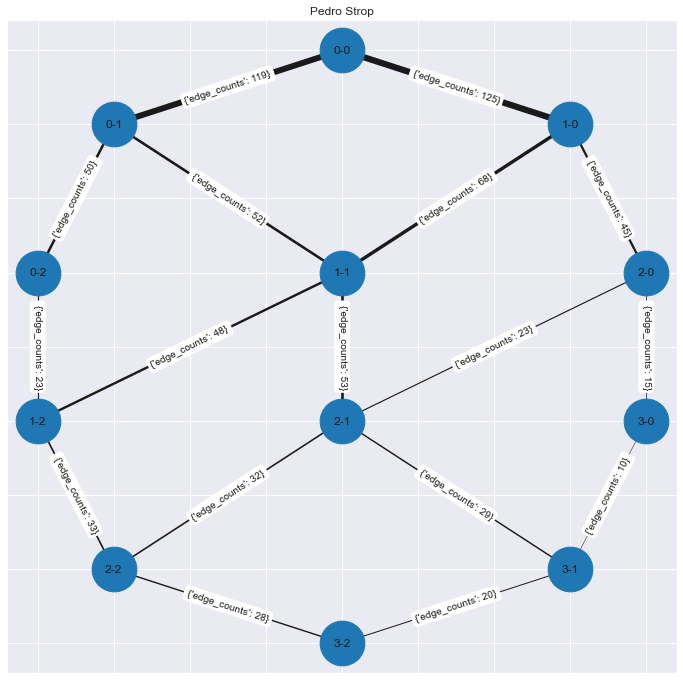

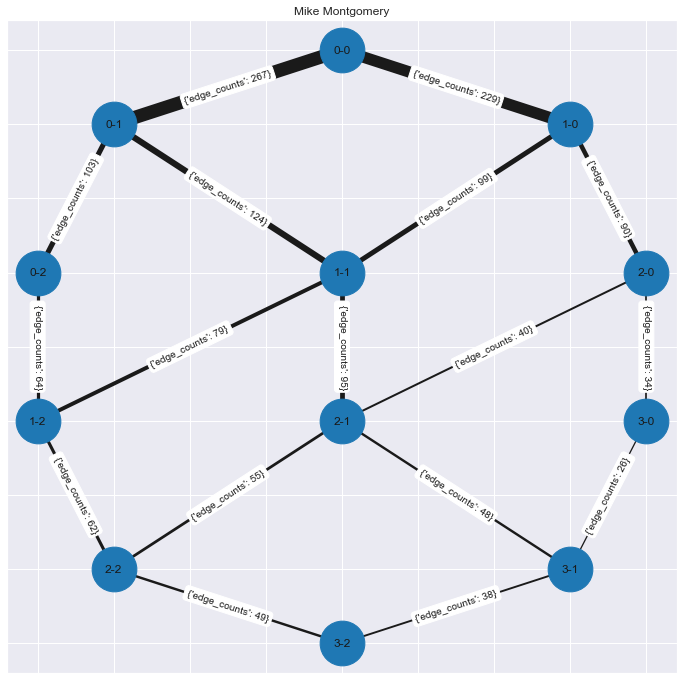

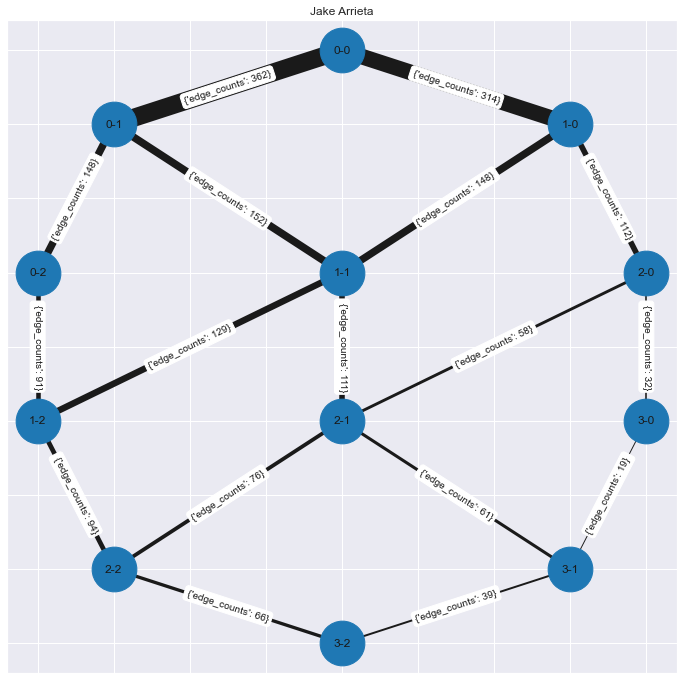

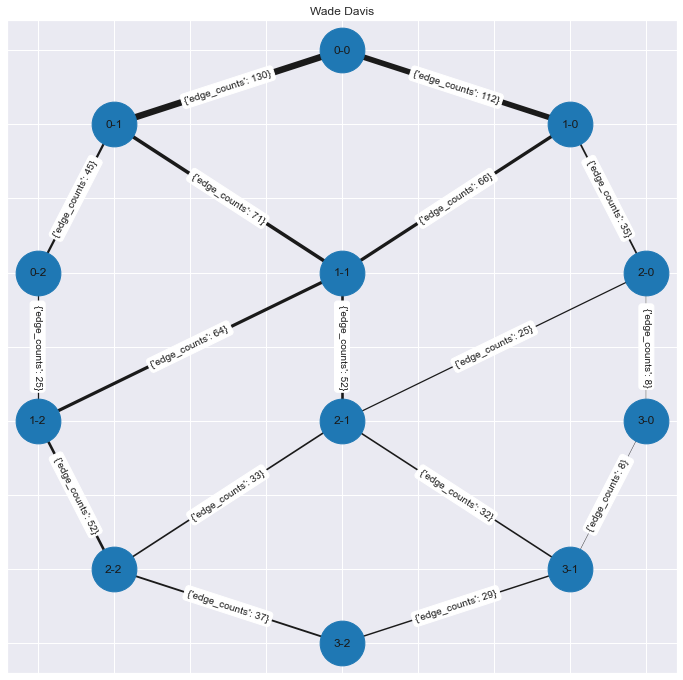

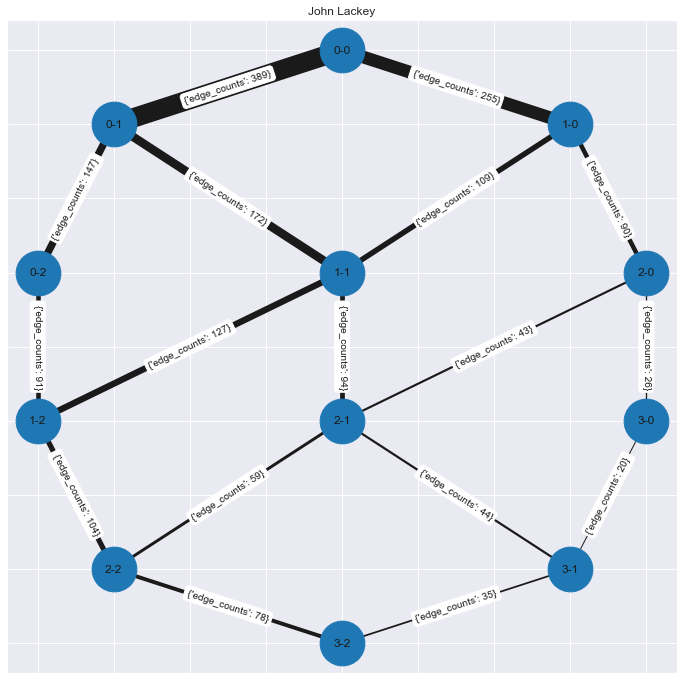

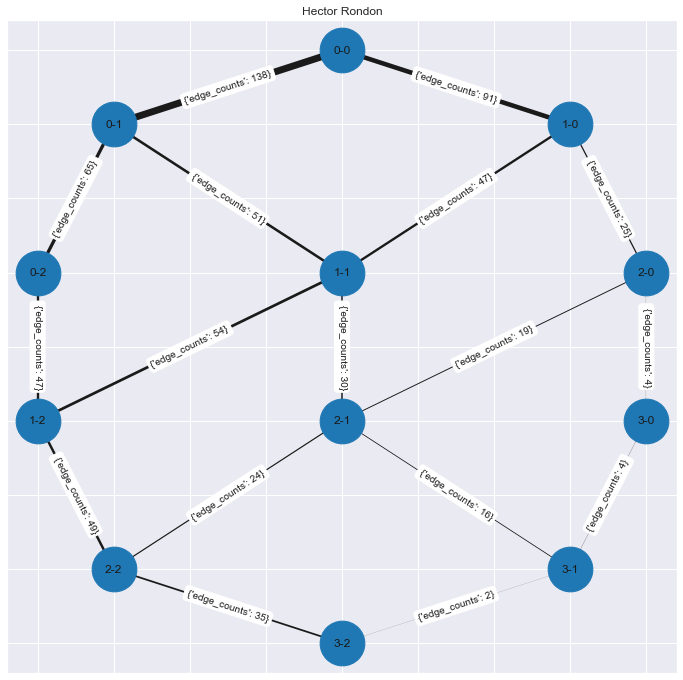

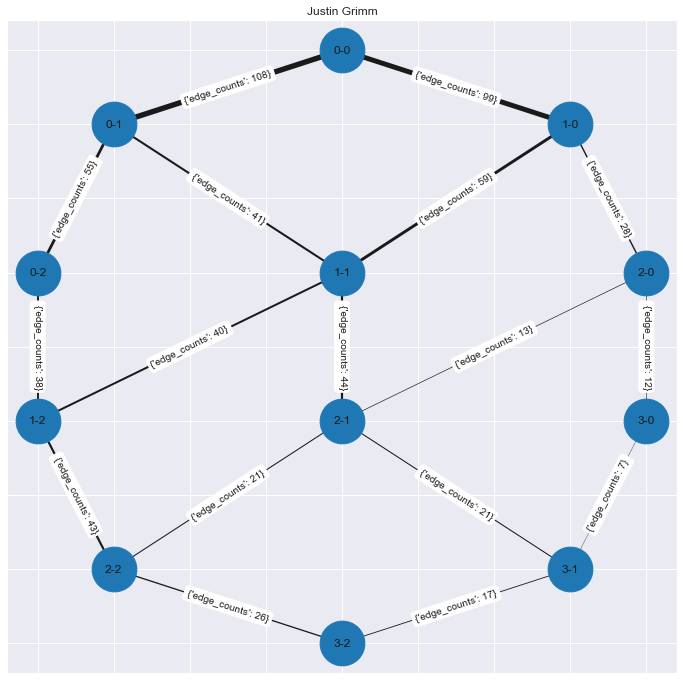

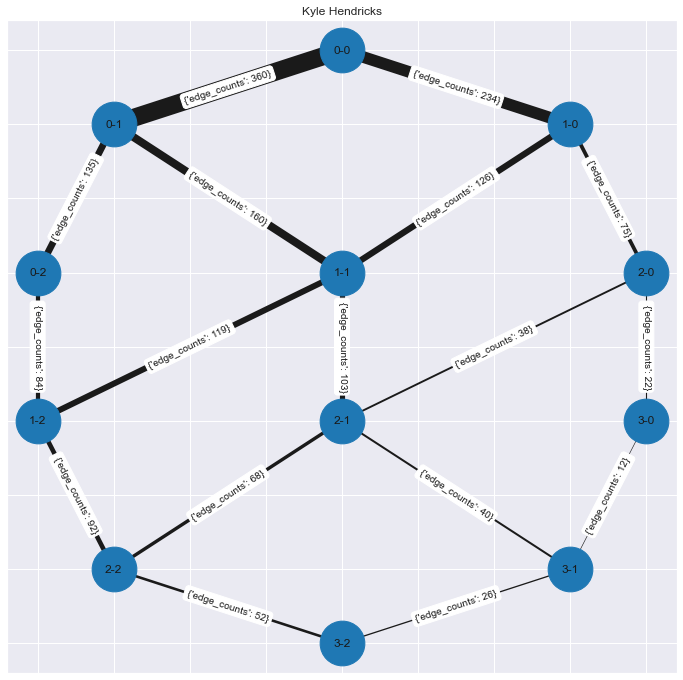

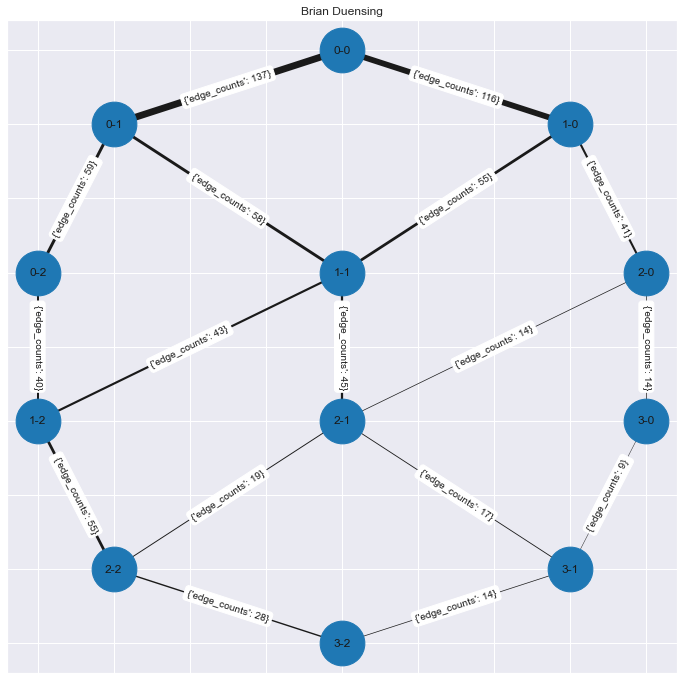

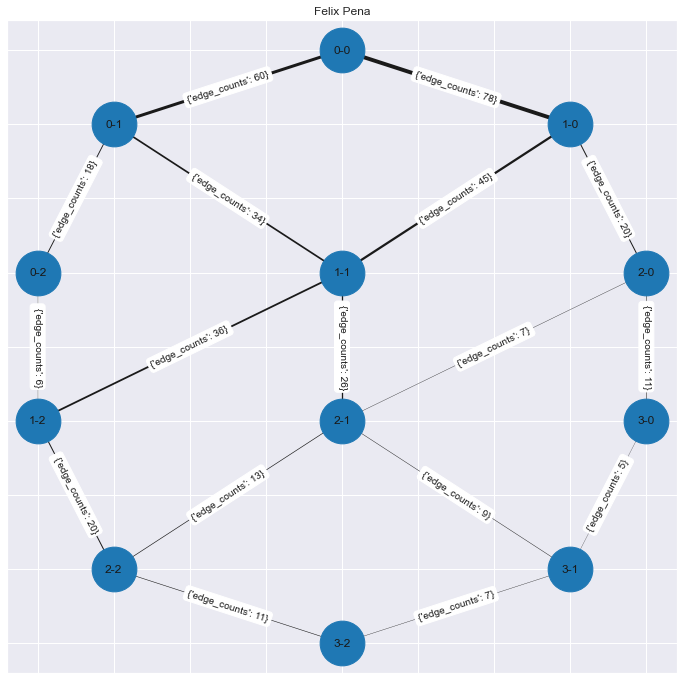

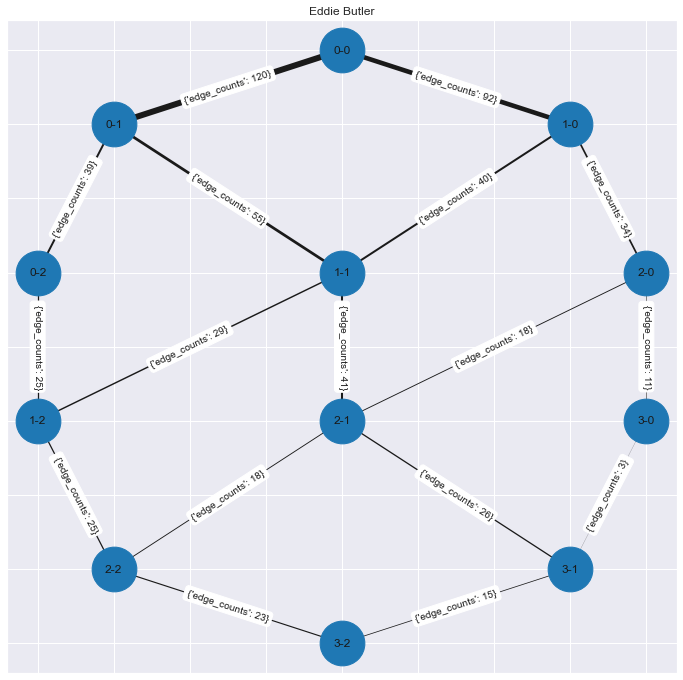

In [20]:
all_pitchers_list = []
for p in cubs_pitching['player_name'].unique():
    pitcher_df = cubs_pitching[cubs_pitching['player_name'] == p]
    all_pitches = []
    for k in count_dict.keys():
        all_pitches.append(countJoin(pitcher_df,starting_count=k))
    final_df = pd.concat(all_pitches)

    connection_counts = final_df.groupby(['pitch_count_start',
                                          'pitch_count_end'])\
                                        .agg({'rn_start':'count'})\
                                        .reset_index().rename(columns={'rn_start':'edge_counts'})

    combined_df2 = pd.merge(final_df,connection_counts,on=['pitch_count_start','pitch_count_end'],how='left')

    G = networkx.from_pandas_edgelist(combined_df2,
                                      source='pitch_count_start',
                                      target='pitch_count_end',
                                      edge_attr='edge_counts')

    edges = G.edges()

    weights = np.array([G[u][v]['edge_counts'] for u,v in edges])

    node_x = [0,0,1,1,-1,-1,-0.75,-0.75,0.75,0.75,0,0]
    node_y = [1,-1,0.25,-0.25,0.25,-0.25,0.75,-0.75,0.75,-0.75,0.25,-0.25]

    node_list = ['0-0','3-2','2-0','3-0','0-2','1-2','0-1','2-2','1-0','3-1','1-1','2-1']

    pos_dict = dict(zip(node_list,np.dstack((node_x,node_y))[0]))

    # Plot a rough network graph here for now
    plt.figure(figsize=(12,12))
    plt.title(p)
    networkx.draw_networkx(G,pos=pos_dict,with_labels=True,width=weights*0.05,node_size=2000)
    networkx.draw_networkx_edge_labels(G,pos=pos_dict)
    
    network_data = json_normalize(networkx.node_link_data(G)['links'])

    long_links = pd.concat([network_data[['edge_counts','source']].rename(columns={'source':'type'}),
                            network_data[['edge_counts','target']].rename(columns={'target':'type'})])

    long_links.reset_index(inplace=True)

    network_data.reset_index(inplace=True)

    long_links.rename(columns={'index':'link_key'},inplace=True)

    node_df = pd.DataFrame(pos_dict).T.reset_index()

    node_df.rename(columns={'index':'node_name',0:'node_x',1:'node_y'},inplace=True)

    network_data = pd.merge(node_df,long_links,left_on='node_name',right_on='type',how='left')

    pitch_breakdown = pitcher_df.groupby(['pitch_count','pitch_type']).agg({'rn':'nunique'}).reset_index()

    all_data = pd.merge(network_data,pitch_breakdown,left_on= 'node_name',right_on='pitch_count',how='left')

    all_data['pitcher_name'] = p
    all_pitchers_list.append(all_data)

The graph above shows how pitches evolved through the count where the edge thickness is the number of pitches. Plays/pitches that do not result in a ball are strike are not shown in this graphic.

This quick all shows all the different kinds of events that happen on a `0-0` count.

Still need to do some extra digging to make sure the balls and strikes are caputered. 

In [21]:
cubs_pitching[(cubs_pitching['player_name'] == 'Jon Lester') & 
              (cubs_pitching['pitch_count'] == '0-0')].groupby(['pitch_count','description']).agg({'rn':'nunique'})

rn
pitch_count description              
0-0         ball                  336
            blocked_ball           11
            called_strike         260
            foul                   77
            foul_bunt               4
            foul_tip                2
            hit_by_pitch            1
            hit_into_play          42
            hit_into_play_no_out   14
            hit_into_play_score    12
            missed_bunt             1
            swinging_strike        61

Quick look at some rows missing from the graph dataframe.

In [22]:
cubs_pitching[(cubs_pitching['player_name'] == 'Jon Lester') & 
              (cubs_pitching['pitch_count'] == '0-0') & 
              ~(cubs_pitching['rn'].isin(lester_df['rn_start'].unique()))].loc[80:85]

,rn,player_name,pitch_type,game_date,home_team,away_team,description,events,strikes,balls,...,plate_z,pfx_x,pfx_z,sz_top,sz_bot,release_speed,pitch_count,sz_center,plate_z_norm,plate_x_norm
81,81,Jon Lester,FF,2017-04-02,STL,CHC,hit_into_play,field_out,0.0,0.0,...,2.3569,0.7568,1.3195,3.875,1.65,90.6,0-0,2.7625,-0.364584,0.098550
82,82,Jon Lester,FF,2017-04-02,STL,CHC,hit_into_play,field_out,0.0,0.0,...,2.4364,0.7276,1.2082,3.985,1.70,90.5,0-0,2.8425,-0.355449,0.115829


In [23]:
full_network = pd.concat(all_pitchers_list)

In [24]:
#save off to use in Tableau
full_network.to_csv('all_pitchers_2021.csv')

In [25]:
full_network[full_network['pitcher_name'] == 'Jon Lester']

,node_name,node_x,node_y,link_key,edge_counts,type,pitch_count,pitch_type,rn,pitcher_name
0,0-0,0.0,1.00,0,404,0-0,0-0,CH,51,Jon Lester
1,0-0,0.0,1.00,0,404,0-0,0-0,CU,109,Jon Lester
2,0-0,0.0,1.00,0,404,0-0,0-0,FC,156,Jon Lester
3,0-0,0.0,1.00,0,404,0-0,0-0,FF,400,Jon Lester
4,0-0,0.0,1.00,0,404,0-0,0-0,SI,103,Jon Lester
...,...,...,...,...,...,...,...,...,...,...
158,2-1,0.0,-0.25,10,67,2-1,2-1,CH,19,Jon Lester
159,2-1,0.0,-0.25,10,67,2-1,2-1,CU,11,Jon Lester
160,2-1,0.0,-0.25,10,67,2-1,2-1,FC,85,Jon Lester
161,2-1,0.0,-0.25,10,67,2-1,2-1,FF,75,Jon Lester
